In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cv_master import Grid2DKernel, SatelliteImageData
from tqdm import tqdm

sns.set_style('whitegrid')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

def iter_by_chunk(iterable, chunksize=10):
    """Helper to get a pre-determined chunk of outputs all together from a iterable"""
    chunks = []
    for item in iterable:
        chunks.append(item)
        if len(chunks) == chunksize:
            yield chunks
            chunks = []
    
    yield chunks

def train_validate_classifer(clf, X_train, y_train, X_val, y_val, metric):
    """The main evalaution function called by each worker"""
    clf.fit(X_train, y_train)
    score = metric(y_val, clf.predict(X_val))
    return score

def cv_classifer(clf, image_data, metric, n_jobs=8, **kws):
    columns = ['ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']
    n_jobs = 8
    scores = []

    # get train validate set by chunk for parallelization
    for chunks in iter_by_chunk(image_data.iter_train_validate(), chunksize=n_jobs):
        # creating delayed objects
        delays = []
        for train_p, val_p in chunks:
            train = image_data.get_data_patches(train_p)
            val = image_data.get_data_patch(val_p)
            X_train, y_train = train[columns], train.label
            X_val, y_val = val[columns], val.label

            delays.append(delayed(train_validate_classifer)(clf, X_train, y_train, X_val, y_val, metric))

        # process batch
        results = Parallel(n_jobs=n_jobs)(delays)

        # store scores
        scores.extend(results)
    
    return scores

In [3]:
kernel = Grid2DKernel(55, 55)
image = SatelliteImageData(kernel, images=['imagem1.txt', 'imagem2.txt'])

clf = LogisticRegression(penalty='l2')

In [4]:
cv_scores = cv_classifer(clf, image, accuracy_score, n_jobs=8)

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

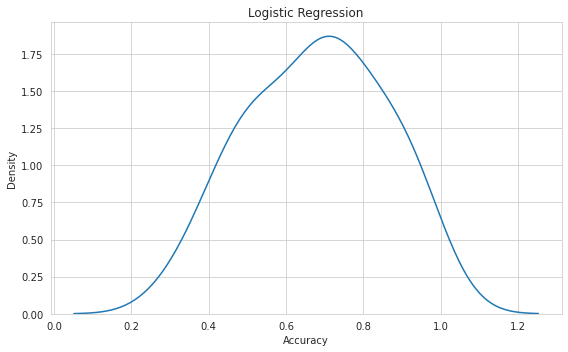

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(cv_scores, ax=ax)

ax.set_xlabel('Accuracy')
ax.set_title("Logistic Regression")

fig.tight_layout()
fig.show()